In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import pandas as pd
import numpy as np
import tensorflow as tf
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from utility import process_md_lines

In [39]:
lines = open('/content/drive/MyDrive/hamdan/data.txt','r',encoding='utf-8').readlines()

In [40]:
df = process_md_lines(lines)

In [41]:
df.head()

,id,text,order,total_lines,url,label
0,0,هى عبارة حساسية عامة و شديدة تحدث في خلال دقائ...,0,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,definition
1,0,و المواد التى تسبب الحساسية المفرطة عديدة و مت...,1,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,definition
2,0,فمثلا حبوب اللقاح المتناثرة فى الجو قد تكون عا...,2,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,definition
3,0,تختلف الأعراض لمثل هذه الحالات فى شدتها بداية ...,3,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,Symptoms
4,0,تشمل الأعراض المصاحبة لهذا المرض ما يلى \n,4,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,Symptoms


In [42]:
no_classes = len(df['label'].unique())
no_classes

5

In [43]:
X_sen = df['text'].to_numpy()
y_sen = pd.get_dummies(df['label']).to_numpy()

In [44]:
X_sen_train, X_sen_test, y_train, y_test = train_test_split(X_sen, y_sen, test_size=0.3, random_state=101)

In [45]:
def split_chars(text):
  return " ".join(list(text))

In [46]:
# Split sequence-level data splits into character-level data splits
X_char_train = [split_chars(sentence) for sentence in X_sen_train]
X_char_test = [split_chars(sentence) for sentence in X_sen_test]

In [47]:
vocab = set()
count = 0
char_count = 0
for text in df['text'].to_numpy():
    tokens = text.split()
    vocab.update(tokens)
    count+=len(tokens)
    char_count+= len(text)

In [48]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

10231

In [49]:
tokens_lens = [len(sentence.split()) for sentence in df['text'].to_numpy()]
WORD_SEQ_LENGTH = int(np.percentile(tokens_lens, 95))
WORD_SEQ_LENGTH

53

In [50]:
char_lens = [len(sentence) for sentence in df['text'].to_numpy()]
CHAR_SEQ_LENGTH = int(np.percentile(char_lens, 95))
CHAR_SEQ_LENGTH

286

In [51]:
BATCH_SIZE = 32
WORD_EMBED_SIZE = 128

In [52]:
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=WORD_SEQ_LENGTH)

In [53]:
text_vectorizer.adapt(df['text'].to_numpy())

In [54]:
word_embedding = tf.keras.layers.Embedding(
    VOCAB_SIZE,
    WORD_EMBED_SIZE,
    mask_zero=True
)

In [55]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [56]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token

In [57]:
char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens= NUM_CHAR_TOKENS,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_sequence_length=CHAR_SEQ_LENGTH
)

In [58]:
text_chars = [" ".join(list(sentence)) for sentence in df['text'].to_numpy()]
char_vectorizer.adapt(text_chars)

In [59]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 70
5 most common characters: ['', '[UNK]', 'ا', 'ل', 'م']
5 least common characters: ['ً', 'v', '6', 'x', '8']


In [60]:
char_embedding = tf.keras.layers.Embedding(
    NUM_CHAR_TOKENS,
    25,
    mask_zero=False
)

In [61]:
# 1. Setup token inputs/model
word_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
word_vectors = text_vectorizer(word_inputs)
word_embeddings = word_embedding(word_vectors)
#x = layers.Conv1D(128, kernel_size=5, padding="same", activation="relu")(word_embeddings)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(word_embeddings)
x = layers.Dropout(0.2)(x)
word_output = layers.Bidirectional(layers.LSTM(64))(x)
word_model = tf.keras.Model(inputs=word_inputs, outputs=word_output)

In [62]:
# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) 
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_bi_lstm)

In [63]:
word_model.output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'bidirectional_2')>

In [64]:
char_model.output

<KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'bidirectional_3')>

In [65]:
# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([word_model.output, char_model.output])

In [75]:
#https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) 
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(no_classes, activation="softmax")(final_dropout)

In [67]:
# 5. Construct model with char and token inputs
model = tf.keras.Model(inputs=[word_model.input, char_model.input],outputs=output_layer,name="model_4_token_and_char_embeddings")

In [68]:
model.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 text_vectorization_2 (TextVect  (None, 53)          0           ['token_input[0][0]']            
 orization)                                                                                       
                                                                                                  
 embedding_2 (Embedding)        (None, 53, 128)      1309568     ['text_vectorization_2[0][0]']   
                                                                                                  
 char_input (InputLayer)        [(None, 1)]          0           [

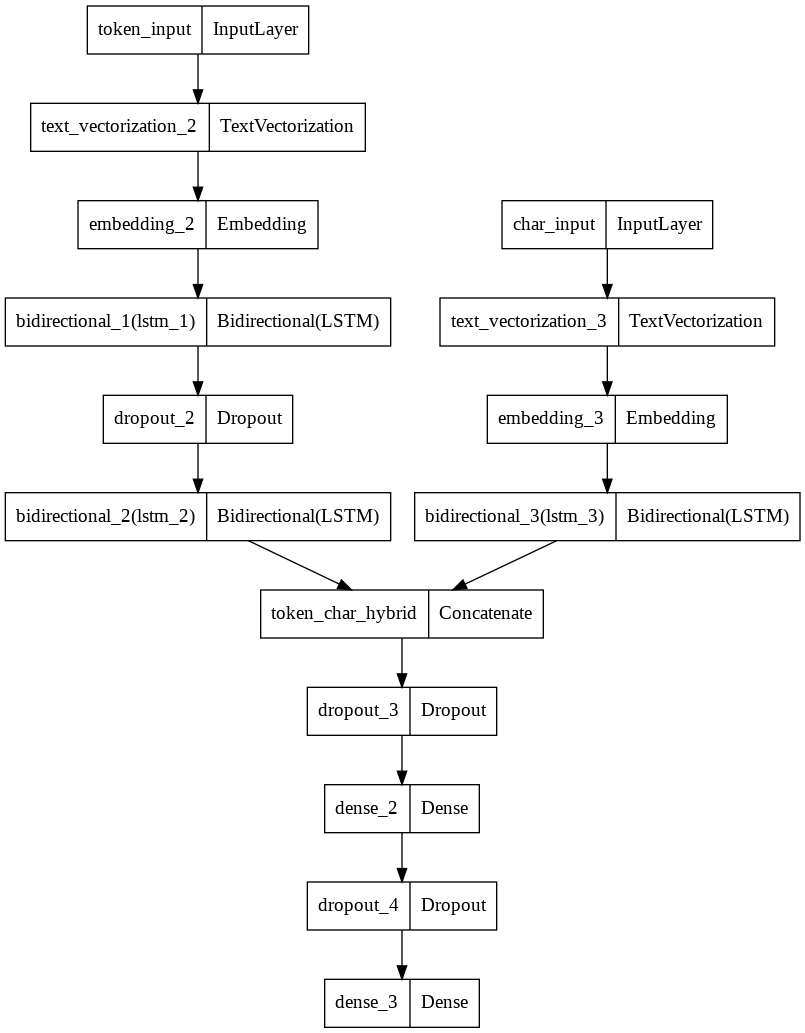

In [69]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [70]:
model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [71]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((X_sen_train, X_char_train)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(y_train) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
test_char_token_data = tf.data.Dataset.from_tensor_slices((X_sen_test, X_char_test))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [72]:
model.fit(train_char_token_dataset, epochs=10, validation_data=test_char_token_dataset)

Epoch 1/10
108/108 [==============================] - 71s 485ms/step - loss: 1.1672 - accuracy: 0.5387 - val_loss: 0.7993 - val_accuracy: 0.7030
Epoch 2/10
108/108 [==============================] - 48s 438ms/step - loss: 0.6108 - accuracy: 0.7772 - val_loss: 0.6185 - val_accuracy: 0.7821
Epoch 3/10
108/108 [==============================] - 44s 412ms/step - loss: 0.3539 - accuracy: 0.8784 - val_loss: 0.6612 - val_accuracy: 0.8187
Epoch 4/10
108/108 [==============================] - 47s 437ms/step - loss: 0.1987 - accuracy: 0.9460 - val_loss: 0.6370 - val_accuracy: 0.8369
Epoch 5/10
108/108 [==============================] - 44s 409ms/step - loss: 0.1189 - accuracy: 0.9675 - val_loss: 0.7130 - val_accuracy: 0.8248
Epoch 6/10
108/108 [==============================] - 44s 405ms/step - loss: 0.0833 - accuracy: 0.9771 - val_loss: 0.6537 - val_accuracy: 0.8322
Epoch 7/10
108/108 [==============================] - 46s 423ms/step - loss: 0.0658 - accuracy: 0.9840 - val_loss: 0.7392 - val_ac